In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_channle = 20
        self.net = nn.Sequential(
            nn.Linear(1, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, 1)
        )
        self.net_k = nn.Sequential(
            nn.Linear(1, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, self.hidden_channle), nn.Tanh(),
            nn.Linear(self.hidden_channle, 1)
        )
    def forward(self,x):
        u=self.net(x)
        k=self.net_k(x)
        return u, k


In [3]:
def u_function(x):
    u, k = model(x)
    return u, k

def f_function(x, a = 0.01):
    u, k = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    f = a * u_xx - k * u - torch.sin(2 * torch.pi * x)
    df = a * u_xxx - k * u_x - 2 * torch.pi * torch.cos(2 * torch.pi * x)
    return f, df, k

def Loss(u, x_u, x_f):
    u_pre, _ = u_function(x_u)
    f_pre, df_pre, k_pre = f_function(x_f)
    # loss
    null =  torch.zeros((x_f.shape[0], 1))
    u_loss = loss_fn(u_pre, u)
    f_loss = loss_fn(f_pre, null)
    g_loss = loss_fn(df_pre, null)
    
    ls = u_loss + f_loss + 0.0001 * g_loss
    ls.backward()
    return ls, k_pre
def Exact_k(x):
    k = 0.1 + torch.exp(-0.5 * ((x - 0.5) / 0.15) ** 2)
    return k

# 真实解

In [4]:
from scipy.integrate import solve_bvp
def k(x):
    return 0.1 + np.exp(-0.5 * (x - 0.5) ** 2 / 0.15 ** 2)
def fun(x, y):
    return np.vstack((y[1], 100 * (k(x) * y[0] + np.sin(2 * np.pi * x))))
def bc(ya, yb):
    return np.array([ya[0], yb[0]])
a = np.linspace(0, 1, 1000)
b = np.zeros((2, a.size))
res = solve_bvp(fun, bc, a, b)
def sol(x):
    return res.sol(x)[0]
def du(x):
    return res.sol(x)[1]
def gen_traindata(num):
    xvals = np.linspace(0, 1, num)
    yvals = sol(xvals)

    return np.reshape(xvals, (-1, 1)), np.reshape(yvals, (-1, 1))
ob_x, ob_u = gen_traindata(8)

[Epoch 1/2000] [loss: 1.2846229076385498]
[Epoch 101/2000] [loss: 0.01787988282740116]
[Epoch 201/2000] [loss: 0.007585104554891586]
[Epoch 301/2000] [loss: 0.017419612035155296]
[Epoch 401/2000] [loss: 0.0007534284377470613]
[Epoch 501/2000] [loss: 0.0007002170896157622]
[Epoch 601/2000] [loss: 0.0006657104822807014]
[Epoch 701/2000] [loss: 0.0006399145349860191]
[Epoch 801/2000] [loss: 0.0006157609168440104]
[Epoch 901/2000] [loss: 0.0005937085952609777]
[Epoch 1001/2000] [loss: 0.0005741432541981339]
[Epoch 1101/2000] [loss: 0.0005722885834984481]
[Epoch 1201/2000] [loss: 0.0005703362985514104]
[Epoch 1301/2000] [loss: 0.0005682986811734736]
[Epoch 1401/2000] [loss: 0.0005661751492880285]
[Epoch 1501/2000] [loss: 0.0005639755399897695]
[Epoch 1601/2000] [loss: 0.0005637456197291613]
[Epoch 1701/2000] [loss: 0.0005635007983073592]
[Epoch 1801/2000] [loss: 0.000563243287615478]
[Epoch 1901/2000] [loss: 0.0005629687802866101]


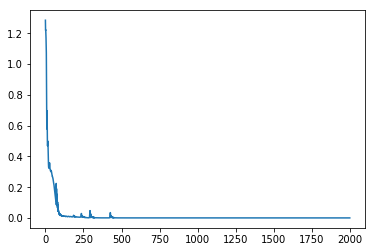

In [5]:
# 制造数据点集
N_f = 1000
x_f = np.random.rand(N_f, 1)
x_f = torch.tensor(x_f.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
x_u = torch.tensor(ob_x, dtype=torch.float32, requires_grad=True).view(-1,1)
u = torch.tensor(ob_u,dtype=torch.float32,requires_grad=True).view(-1,1)
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1, verbose=False)
epochs = 2000
Losses = []
K_pre = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss, k = Loss(u, x_u, x_f)
    Losses.append(loss.item())
    R = k.squeeze(-1).detach().numpy().copy()
    K_pre.append(R)
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()

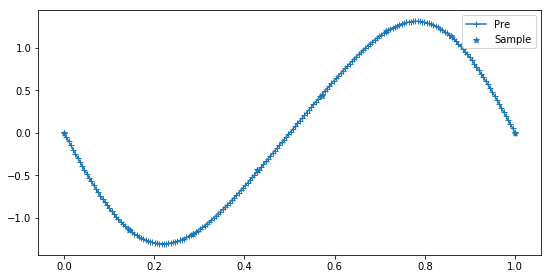

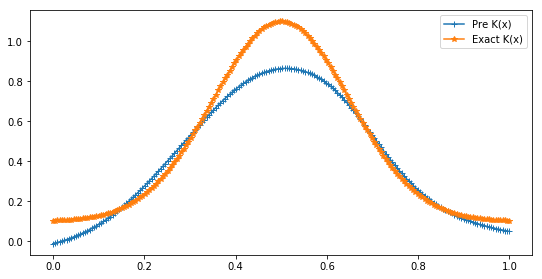

In [6]:
x = torch.linspace(0, 1, 200, dtype=torch.float32).view(-1,1)
u_pre, Knp = u_function(x)
xnp = x.numpy()
Unp = u_pre.detach().numpy()
Kex = Exact_k(x)
# Pre plot:
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Unp,marker='+',label='Pre')
plt.scatter(x_u.detach().numpy(),u.detach().numpy(),marker='*',label='Sample')
plt.legend()
plt.show()

fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Knp.detach().numpy(),marker='+',label='Pre K(x)')
plt.plot(xnp,Kex,marker='*',label='Exact K(x)')
plt.legend()
plt.show()

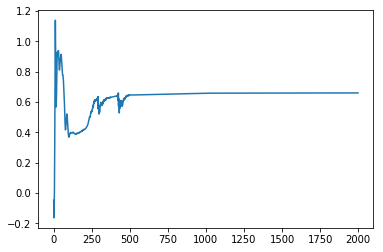

In [7]:
a = []
for i in range(len(K_pre)):
    a.append(K_pre[i][0])
plt.plot(a)